In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data_downselect = pd.read_pickle('D:/PSED/Jarvis_cfid/data_downselect.pkl')

In [2]:
sum(data_downselect.crys=='triclinic')

275

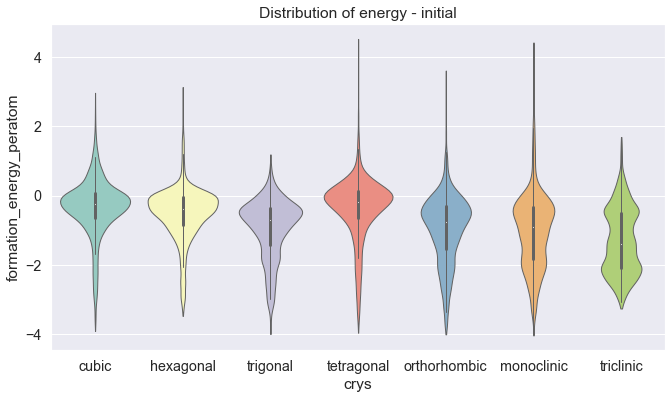

In [3]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(11,6))
order = ['cubic', 'hexagonal', 'trigonal', 'tetragonal', 'orthorhombic', 'monoclinic', 'triclinic']
sns.violinplot(data=data_downselect, x='crys', y='formation_energy_peratom', palette='Set3', bw=.2, cut=1, linewidth=1, order=order)
# ax.set(ylim=(-.7,2))
plt.title('Distribution of energy - initial')
plt.savefig("D:/PSED/plots/E_jarvis.png", dpi=200)

In [10]:
import numpy as np
data_downselect[(data_downselect.crys == 'triclinic') & (data_downselect.formation_energy_peratom > 0)].shape[0]

25